In [11]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import missingno as msno
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd


in the project, df = dataset
last time i used certificate and stars, but this time i avoided them.
instead, since im working with fewer variables, i tried to make the model not go to overfitting by cross validation etc (you will see later)
in the dataset there were some minor adjustments i had to make
Gross had 'nnn,nnn,nn...' format, so i had to remove the , and turn it to float
runtime had 'n min' format so i removed min and truend it into float
in released_Year there was 1 value with PG, removed the entire row for simplicity
divided the features into numerical and categorical (will be useful for pipelines later on)
and finally split

<Axes: >

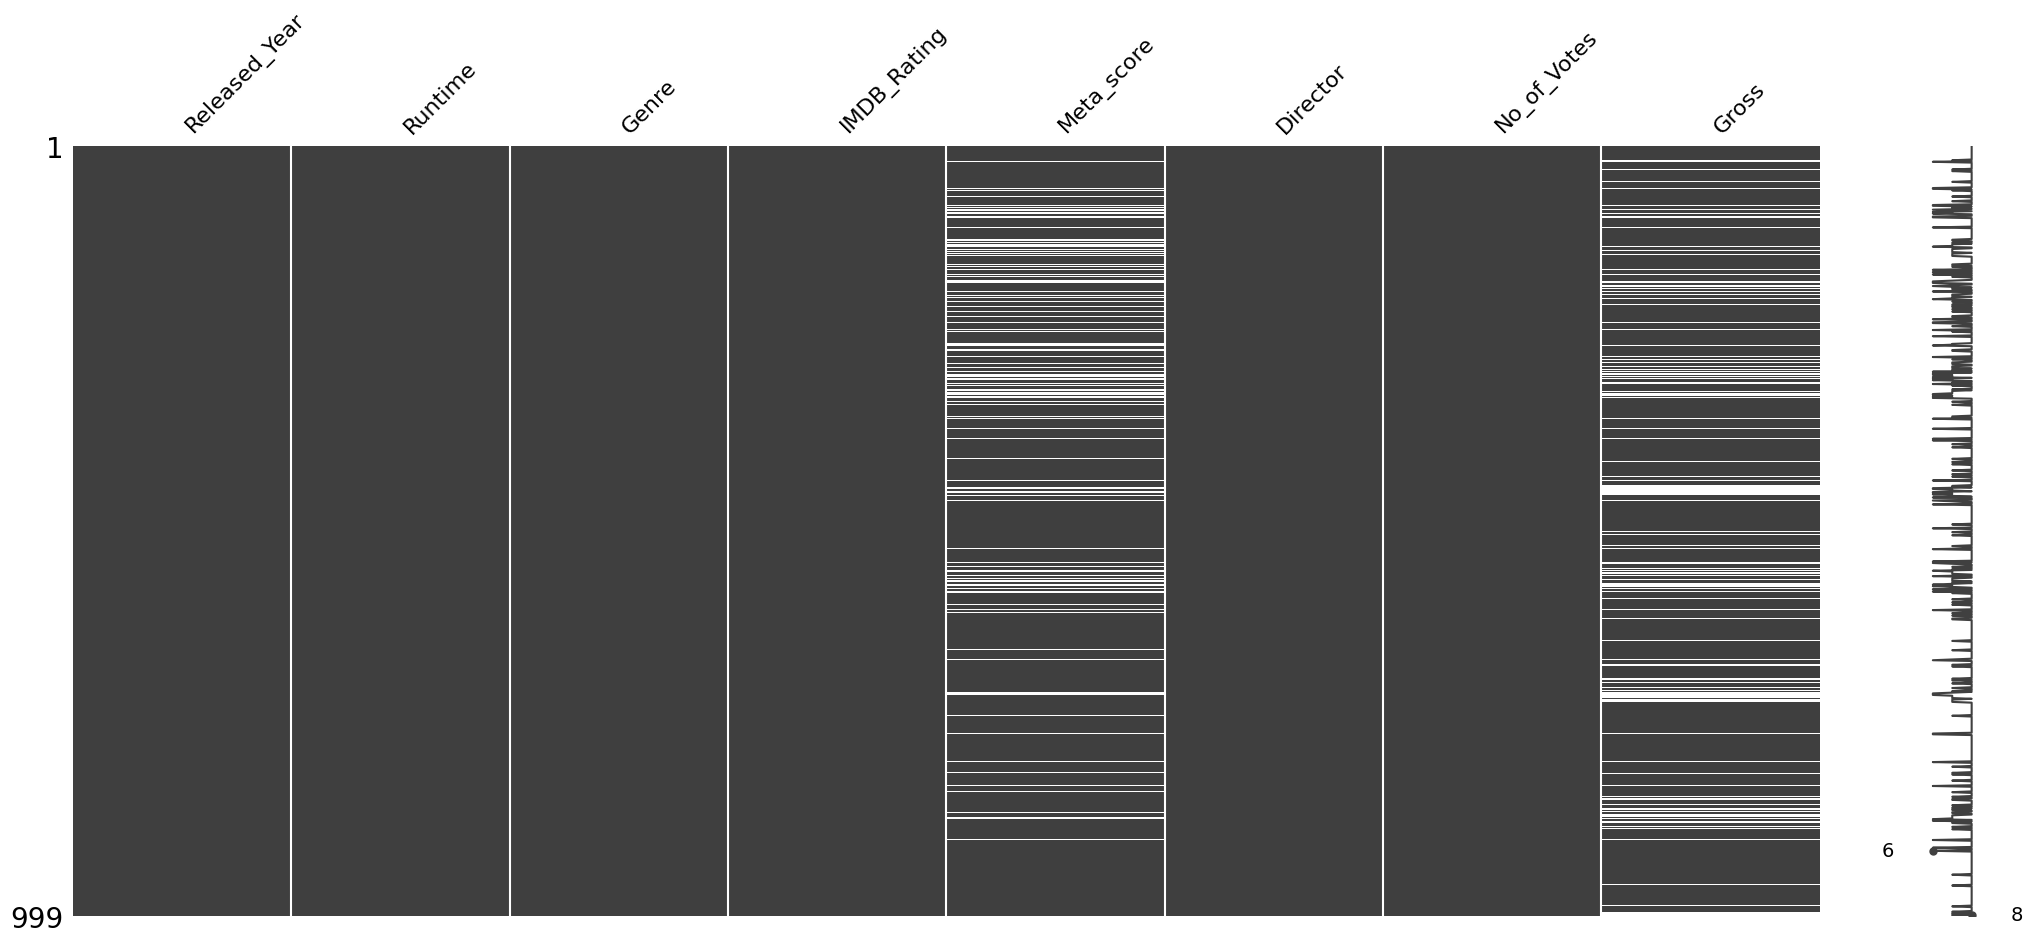

In [12]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv')
df = df.drop(columns=['Poster_Link', 'Overview', 'Series_Title', 'Star1', 'Star2', 'Star3', 'Star4', 'Certificate'])

if 'Released_Year' in df.columns and 'PG' in df['Released_Year'].values:
    df = df[df['Released_Year'] != 'PG']

df['Gross'] = df['Gross'].str.replace(',', '').astype('float')
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype('float')

df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df = df.dropna(subset=['Released_Year'])

df['Released_Year'] = df['Released_Year'].astype(int)

X = df.drop('IMDB_Rating', axis=1)
y = df['IMDB_Rating']

numerical_features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross'] 
categorical_features = ['Genre', 'Director'] 

X[categorical_features] = X[categorical_features].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


msno.matrix(df)

these are the pipelines for the numerical and categorical features
ordinalEncoder made no sense since had an order while my categories dont

In [13]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])
#first used ordinalEncoder, remembered there is no order, so i see that
#with onehotencoding the accuracy is higher. (mae is lower)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


the preprocessor transforms the features.
used 3 models to see the best one.
LinearRegression is supervised,
RandomForest/GradientBoosting are ensemble.
used hyperparameter tuning with GridSearchCV, which also cross validates
the best_estimator finds the best model
mae is the difference between the prediction and the actual value
R2 explains how well the model fits the data

The system i used may be disadvantageous if i had more columns, but with these few columns i can do it:
basically i made 2 lists of every feature name, 1 categorical and 1 numerical.
then i put the feature name on preprocessor, and only on gridSearchCV i started to train the training set at every iteration.
This way i can guarantee 1) no data leakage, 2) simpler to read, 3)easier to use on GridSearch, 4)I know which ones I put on categorical_features, which features i put on the numerical, instead of printing it out every time to guarantee.

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
    ('numerical', numerical_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_features)
], remainder='passthrough'
)

models = {
    'LinearRegression': (LinearRegression(), {}),
    'RandomForest': (RandomForestRegressor(random_state=42), {'model__n_estimators': [100, 200, 300], 
                      'model__max_depth': [5, 7, 8, 10]}),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {'model__n_estimators': [50, 75, 100], 'model__learning_rate': [0.01, 0.1]}),
}
#declare best_model through all the loops, the reason i guess is a programming issue
best_model = None
best_mae = float('inf')

# iterate all models
for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # grid search cross validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1)
    
    #ONLY ON TRAINING SET, ELSE WILL BE DATA LEAKAGE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    grid_search.fit(X_train, y_train)

    currentModel = grid_search.best_estimator_

    y_pred = currentModel.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - Best MAE: {mae}")

    if mae < best_mae:
        best_mae = mae
        best_model = currentModel 
        best_model_name = model_name
print(f"\nBest Model: {best_model_name} with Mean Absolute Error: {best_mae}")



print("Shape of X_test:", X_test.shape)
print("Shape of X_train:", X_train.shape)


y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
print(f"R2 on best model: {r2_rf}")

Training LinearRegression
Fitting 10 folds for each of 1 candidates, totalling 10 fits
LinearRegression - Best MAE: 0.20747590683829045
Training RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits
RandomForest - Best MAE: 0.1410375542191583
Training GradientBoosting
Fitting 10 folds for each of 6 candidates, totalling 60 fits
GradientBoosting - Best MAE: 0.15042654528970242

Best Model: RandomForest with Mean Absolute Error: 0.1410375542191583
Shape of X_test: (200, 7)
Shape of X_train: (799, 7)
R2 on best model: 0.5028175853152743


the results are.... underwhelming
R2 is 0.5 but at least mae=0.14.
the heat map shows only 2 correlations. between No_of_votes/gross of 0.5, and Meta_score/Released_Year of -0.3


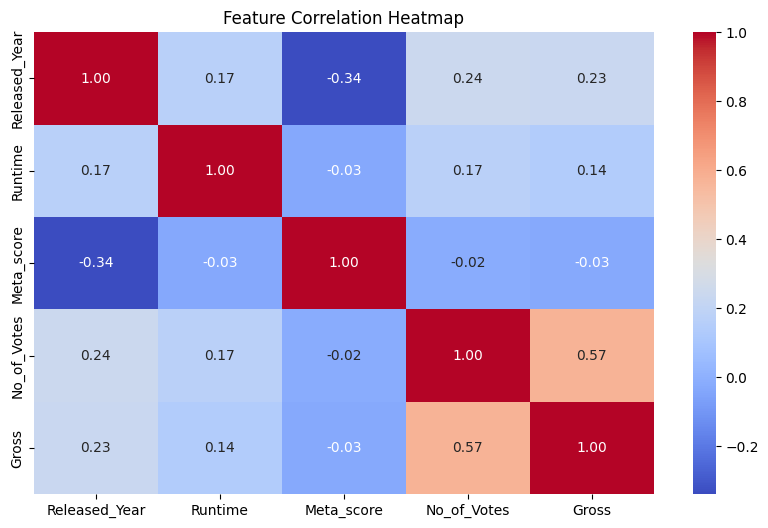

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_numerical = df[numerical_features]

correlation_matrix = df_numerical.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()



I think the correlations make sense, No_of_votes means seen by more people, and gross means more people payed for it, so obvious!